In [113]:

import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

errorbar_func = lambda x: (np.max((x.mean()-x.std(), 0)), np.min((x.mean()+x.std(), 1)))


# Plotting AUC scores

## Main paper

In [73]:
# load everyhtin in results/full in a single dataframe
files_list = os.listdir('../src/results/full')
df = pd.DataFrame()
for file in files_list:
    if file.endswith('.csv') and file.startswith('ER'):
        df = pd.concat([df, pd.read_csv('../src/results/full/' + file)])

df.drop('Unnamed: 0', axis=1, inplace=True)


# Set a "post_proc" column with True if the explainer has postproc in the name
df['post_proc'] = df['explainer'].apply(lambda x: 'Post-proc.' if 'postproc' in x else 'Raw')
# remove postproc from the name
df['explainer'] = df['explainer'].apply(lambda x: x.replace('_postproc', ''))


print(df['explainer'].unique())

# substitute 'IntegratedGradients' with 'IG'
df['explainer'] = df['explainer'].apply(lambda x: 'IG' if x == 'IntegratedGradients' else x)

# GNNExplainer_0.01 with GNNExplainer
df['explainer'] = df['explainer'].apply(lambda x: 'GNNExp.' if x == 'GNNExplainer' else x)

# Deconvolution with Deconv.
df['explainer'] = df['explainer'].apply(lambda x: 'Deconv.' if x == 'Deconvolution' else x)

# SubgraphX with SubX
df['explainer'] = df['explainer'].apply(lambda x: 'SubX' if x == 'SubgraphX' else x)
random_baseline_df = df[df['explainer'] == 'Random'].copy()
# order the explaienr with 'GNNExp.' first, then 'IG', 'Decov.', 'LRP' and remove the lines with 'Random'
df = df[(df['explainer'] != 'Random') & (df['explainer'] != 'SubX')] # 

df['explainer'] = pd.Categorical(df['explainer'], ['GNNExp.', 'IG', 'Deconv.', 'LRP',]) #
df = df.sort_values('explainer')

df = df.sort_values('post_proc', ascending=False)

['Deconvolution' 'IntegratedGradients' 'LRP' 'GNNExplainer' 'Random'
 'SubgraphX' 'FlowX']


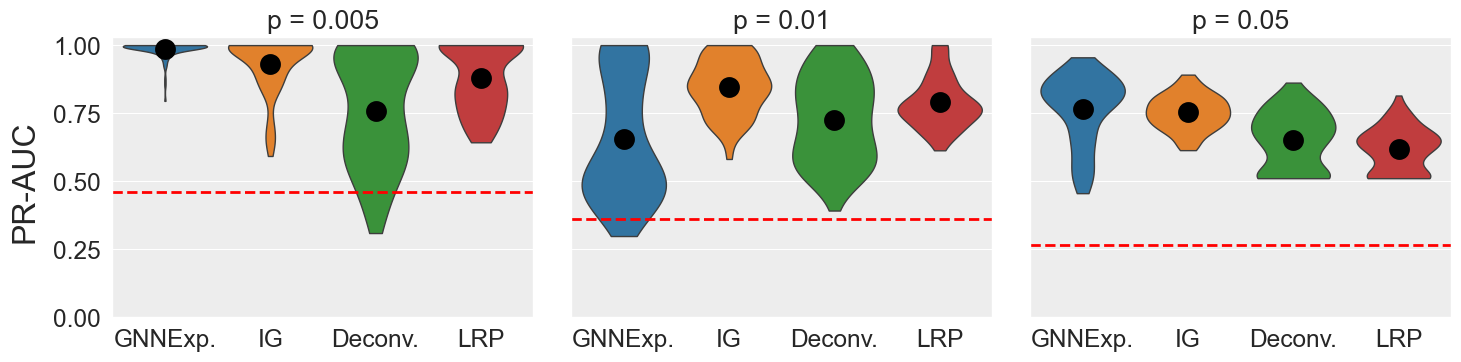

In [74]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge

sns.set_context('paper', font_scale=2)

# get a background color slightly less dark
sns.set_style('darkgrid', {'axes.facecolor': '0.93'})

ps = df['p_edge'].unique()
ps.sort()

h = 0.33
lf = 0.8

lfs = df['labelled_fraction'].unique()
lfs.sort()

fig, axs = plt.subplots(1, len(ps), figsize=(15, 4), sharey=True)


for j, p in enumerate(ps):

    sns.violinplot(x='explainer', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') ],
                    ax=axs[j],hue='explainer', cut=0, inner=None)
    sns.pointplot(x='explainer', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw')],
                    ax=axs[j], linestyles='', markersize=10, lw=0, markers='o', color='black', markeredgewidth=5)
    axs[j].set_title(f'p = {p}')
    #axs[j].axhline(1, ls='--', color='r', lw=2)
    #random_pr_auc = df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']=='Random')]['pr_auc'].mean()
    #axs[j].axhline(0.25, ls='--', color='r', lw=2)
    axs[j].set_ylabel('')
    
    axs[j].set_ylim(0., 1.03)
    axs[j].set_xlabel('')
    random_mean = random_baseline_df[(random_baseline_df['p_edge'] == p) & (random_baseline_df['homophily'] == h) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['pr_auc'].mean()
    axs[j].axhline(random_mean, ls='--', color='r', lw=2)


#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('PR-AUC')

fig.tight_layout()
fig.savefig(f'../src/results/figures/violinplot_pr_auc_h_{h}.pdf')


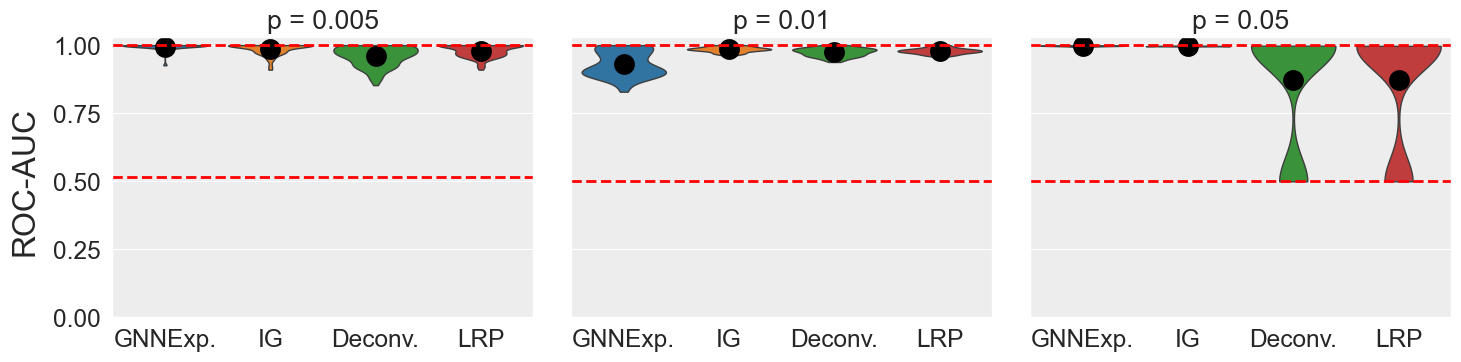

In [75]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge



sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid', {'axes.facecolor': '0.93'})

ps = df['p_edge'].unique()
ps.sort()

h = 0.33
lf = 0.8

lfs = df['labelled_fraction'].unique()
lfs.sort()

fig, axs = plt.subplots(1, len(ps), figsize=(15, 4), sharey=True)


for j, p in enumerate(ps):
    sns.violinplot(x='explainer', y='roc_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']!='Random')],
                    ax=axs[j],hue='explainer', cut=0, inner=None)
    sns.pointplot(x='explainer', y='roc_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']!='Random')],
                    ax=axs[j], linestyles='', markersize=10, lw=0, markers='o', color='black', markeredgewidth=5)
    axs[j].set_title(f'p = {p}')
    axs[j].axhline(1, ls='--', color='r', lw=2)
    #random_pr_auc = df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']=='Random')]['pr_auc'].mean()
    random_mean = random_baseline_df[(random_baseline_df['p_edge'] == p) & (random_baseline_df['homophily'] == h) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['roc_auc'].mean()
    axs[j].axhline(random_mean, ls='--', color='r', lw=2)
    axs[j].set_ylabel('')
    
    axs[j].set_ylim(0., 1.03)
    axs[j].set_xlabel('')


#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('ROC-AUC')

fig.tight_layout()
fig.savefig(f'../src/results/figures/violinplot_roc_auc_h_{h}.pdf')


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/555380645.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/555380645.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
/var/folders/jn/nw79

explainer  post_proc 
GNNExp.    Post-proc.    0.987956
           Raw           0.985256
IG         Post-proc.    1.000000
           Raw           0.929966
Deconv.    Post-proc.    1.000000
           Raw           0.757318
LRP        Post-proc.    1.000000
           Raw           0.878729
Name: pr_auc, dtype: float64
explainer  post_proc 
GNNExp.    Post-proc.    0.676532
           Raw           0.653922
IG         Post-proc.    1.000000
           Raw           0.845536
Deconv.    Post-proc.    1.000000
           Raw           0.726351
LRP        Post-proc.    1.000000
           Raw           0.790052
Name: pr_auc, dtype: float64
explainer  post_proc 
GNNExp.    Post-proc.    0.765719
           Raw           0.765379
IG         Post-proc.    1.000000
           Raw           0.753246
Deconv.    Post-proc.    0.878228
           Raw           0.651802
LRP        Post-proc.    0.878228
           Raw           0.618869
Name: pr_auc, dtype: float64


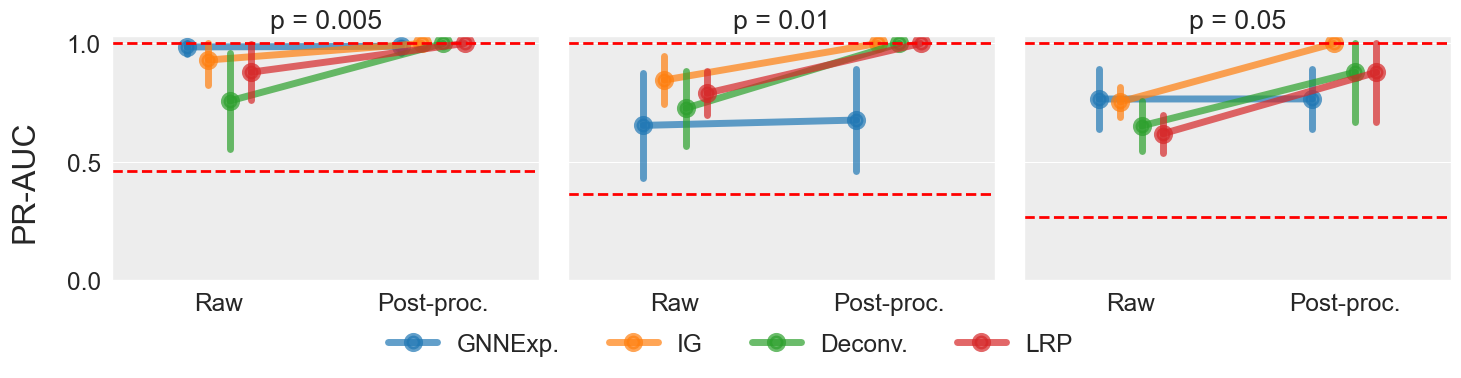

In [86]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge


sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid', {'axes.facecolor': '0.93'})


ps = df['p_edge'].unique()
ps.sort()

h = 0.33
lf = 0.8

lfs = df['labelled_fraction'].unique()
lfs.sort()

fig, axs = plt.subplots(1, len(ps), figsize=(15, 4), sharey=True)


for j, p in enumerate(ps):
    sns.pointplot(x='post_proc', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')],
                    ax=axs[j],hue='explainer', markersize=10, lw=5, legend=(j==0), errorbar=errorbar_func, alpha=0.7, dodge=.3)
    if j==0:
        axs[j].get_legend().remove()
    print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
    axs[j].set_title(f'p = {p}')
    axs[j].axhline(1, ls='--', color='r', lw=2)
    #random_pr_auc = df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']=='Random')]['pr_auc'].mean()
    random_mean = random_baseline_df[(random_baseline_df['p_edge'] == p) & (random_baseline_df['homophily'] == h) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['pr_auc'].mean()
    axs[j].axhline(random_mean, ls='--', color='r', lw=2)
    axs[j].set_ylabel('')
    
    axs[j].set_ylim(0., 1.03)
    axs[j].set_xlabel('')

#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('PR-AUC')

# tight layout but leave some space for the legend on the right
fig.tight_layout()

fig.legend(title='',loc='lower center', ncols=4, frameon=False)
fig.subplots_adjust(bottom=0.25)
fig.savefig(f'../src/results/figures/pointplot_pr_auc_h_{h}_with_PP.pdf')


In [94]:
# load everyhtin in results/full in a single dataframe
files_list = os.listdir('../src/results/full')
df = pd.DataFrame()
for file in files_list:
    if file.endswith('.csv') and file.startswith('real_datasets'):
        df = pd.concat([df, pd.read_csv('../src/results/full/' + file)])

df.drop('Unnamed: 0', axis=1, inplace=True)


# Set a "post_proc" column with True if the explainer has postproc in the name
df['post_proc'] = df['explainer'].apply(lambda x: 'Post-proc.' if 'postproc' in x else 'Raw')
# remove postproc from the name
df['explainer'] = df['explainer'].apply(lambda x: x.replace('_postproc', ''))

# substitute 'IntegratedGradients' with 'IG'

df['explainer'] = df['explainer'].apply(lambda x: 'IG' if x == 'IntegratedGradients' else x)

# GNNExplainer_0.01 with GNNExplainer

df['explainer'] = df['explainer'].apply(lambda x: 'GNNExp.' if x == 'GNNExplainer' else x)

# Deconvolution with Deconv.
df['explainer'] = df['explainer'].apply(lambda x: 'Deconv.' if x == 'Deconvolution' else x)

# order the explaienr with 'GNNExp.' first, then 'IG', 'Decov.', 'LRP'
df['dataset_type'] = df['dataset_type'].apply(lambda x: 'OGBN-ArXiv' if x == 'Arxiv' else x)
random_baseline_df = df[df['explainer'] == 'Random'].copy()
df = df[df['explainer'] != 'Random']
df['explainer'] = pd.Categorical(df['explainer'], ['GNNExp.', 'IG', 'Deconv.', 'LRP'])
df = df.sort_values('explainer')

df = df.sort_values('post_proc', ascending=True)
# substitute Arxiv with OGBN-ArXiv in the dataset_type column



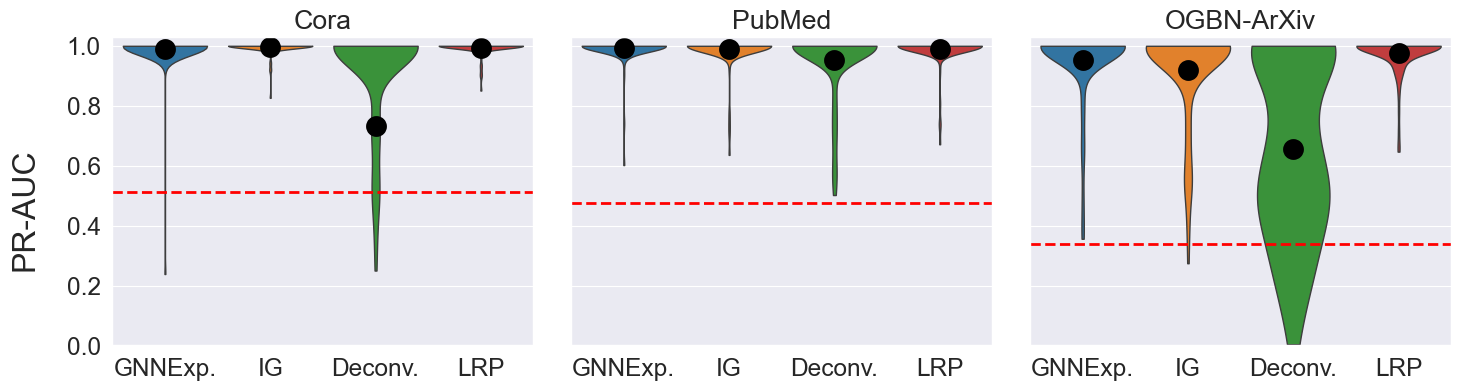

In [95]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge

sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid')


lf = 0.8
datasets = ['Cora', 'PubMed', 'OGBN-ArXiv']
fig, axs = plt.subplots(1, 3,  figsize=(15, 4.), sharey=True)



for i,dataset in enumerate(datasets):
    sns.violinplot(x='explainer', y='pr_auc',  data=df[(df['dataset_type'] == dataset) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw')], ax=axs[i],
                    hue='explainer', cut=0, inner=None, legend=False)
    sns.pointplot(x='explainer', y='pr_auc',   data=df[(df['dataset_type'] == dataset) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw')],
                    ax=axs[i], linestyles='', markersize=10, lw=0, markers='o', color='black', markeredgewidth=5, legend=False)
    axs[i].set_title(f'{dataset}')
    # draw two horizontal lines at 0.5 and 1
    #axs[i].axhline(1, ls='--', color='r', lw=2)
    axs[i].set_ylabel('')
    random_mean = random_baseline_df[(random_baseline_df['dataset_type'] == dataset) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['pr_auc'].mean()
    axs[i].axhline(random_mean, ls='--', color='r', lw=2)

    
    if i == 0:
        #axs[j, i].set_ylabel('Precision-Recall AUC')
        axs[i].set_ylim(-0., 1.03)
    axs[i].set_xlabel('')

fig.supylabel('PR-AUC')
fig.tight_layout()
fig.subplots_adjust(top=0.93)
#fig.legend(title='Explainer',loc='upper center', bbox_to_anchor=(0.945, 0.8))
fig.savefig(f'../src/results/figures/real_datasets_violinplot_pr_auc.pdf')


In [100]:
import matplotlib as mpl

# create a dataframe with the mean pr_auc for each explainer and dataset
# the index has two levels, dataset_type and post_proc, the columns are the explainer and the values are the mean pr_auc +- std
df = df.sort_values('post_proc', ascending=False)
df_mean = df.groupby(['dataset_type', 'post_proc', 'explainer', ])['pr_auc'].mean().unstack()
df_final = df.groupby(['dataset_type', 'post_proc', 'explainer', ])['pr_auc'].apply(lambda x: f'{x.mean()*100:.1f}$\pm${x.std()*100:.1f}').unstack()
df_mean.sort_index(ascending=False, inplace=True)
df_final.sort_index(ascending=False, inplace=True)
# sort df_final as "Cora", "PubMed", "OGBN-ArXiv"

df_mean = df_mean.reindex(['Cora', 'PubMed', 'OGBN-ArXiv'], level=0)
df_final = df_final.reindex(['Cora', 'PubMed', 'OGBN-ArXiv'], level=0)


# create three color maps for the three p_edge values, and store them in a dictionary
# each colormap normalized for the values in the dataframe corresponding to the p_edge value
cmaps = {}

cmaps_names = ['Greens', 'Blues', 'Purples']
clip_values = []
for k, dataset in enumerate(df_mean.index.get_level_values(0).unique()):
    cmap = sns.color_palette(cmaps_names[k], as_cmap=True)
    #norm = mpl.colors.LogNorm(df_mean.loc[dataset].min().min(), df_mean.loc[dataset].max().max())

    #norm = plt.Normalize(df_mean.loc[dataset].min().min(), df_mean.loc[dataset].max().max(), clip=True)
    if k <2:
        norm = plt.Normalize(0.98, 1, clip=True)
    else:
        norm = plt.Normalize(0.9, 1, clip=True)
    cmaps[dataset] = cmap(norm(df_mean.loc[dataset]))

import matplotlib as mpl

def relative_luminance(rgba) -> float:
            """
            Calculate relative luminance of a color.

            The calculation adheres to the W3C standards
            (https://www.w3.org/WAI/GL/wiki/Relative_luminance)

            Parameters
            ----------
            color : rgb or rgba tuple

            Returns
            -------
            float
                The relative luminance as a value from 0 to 1
            """
            r, g, b = (
                x / 12.92 if x <= 0.04045 else ((x + 0.055) / 1.055) ** 2.4
                for x in rgba[:3]
            )
            return 0.2126 * r + 0.7152 * g + 0.0722 * b


def custom_background(s):
    text_color_threshold = 0.408
    dataset = s.name[0]
    pp = s.name[1]
    j = 0 if pp == 'Raw' else 1
    curr_cmap = cmaps[dataset]
    text_darks = ['dark' if relative_luminance(curr_cmap[j][i]) < text_color_threshold else 'light' for i in range(len(s))]
    text_colors = ["#f1f1f1" if x == 'dark' else "#000000" for x in text_darks]

    return [f'background-color: {mpl.colors.rgb2hex(curr_cmap[j][i])}; color: {text_colors[i]}' for i in range(len(s))]



df_final.style.apply(custom_background, axis=1).format(escape='latex-math').to_latex('../src/results/tables/real_datasets_pr_auc.tex', convert_css=True)
#.applymap(lambda x: f'{x}±{df_std.loc[x]:.2f}')



<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1871519146.py:7: SyntaxWarning: invalid escape sequence '\p'
  df_final = df.groupby(['dataset_type', 'post_proc', 'explainer', ])['pr_auc'].apply(lambda x: f'{x.mean()*100:.1f}$\pm${x.std()*100:.1f}').unstack()
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1871519146.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(['dataset_type', 'post_proc', 'explainer', ])['pr_auc'].mean().unstack()
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1871519146.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

## with subgraphX

In [173]:
# load everyhtin in results/full in a single dataframe
files_list = os.listdir('../src/results/full')
df = pd.DataFrame()
for file in files_list:
    if file.endswith('.csv') and file.startswith('ER'):
        df = pd.concat([df, pd.read_csv('../src/results/full/' + file)])

df.drop('Unnamed: 0', axis=1, inplace=True)


# Set a "post_proc" column with True if the explainer has postproc in the name
df['post_proc'] = df['explainer'].apply(lambda x: 'Post-proc.' if 'postproc' in x else 'Raw')
# remove postproc from the name
df['explainer'] = df['explainer'].apply(lambda x: x.replace('_postproc', ''))


print(df['explainer'].unique())

# substitute 'IntegratedGradients' with 'IG'
df['explainer'] = df['explainer'].apply(lambda x: 'IG' if x == 'IntegratedGradients' else x)

# GNNExplainer_0.01 with GNNExplainer
df['explainer'] = df['explainer'].apply(lambda x: 'GNNExp.' if x == 'GNNExplainer' else x)

# Deconvolution with Deconv.
df['explainer'] = df['explainer'].apply(lambda x: 'Deconv.' if x == 'Deconvolution' else x)

# SubgraphX with SubX
df['explainer'] = df['explainer'].apply(lambda x: 'SubX' if x == 'SubgraphX' else x)
random_baseline_df = df[df['explainer'] == 'Random'].copy()
# order the explaienr with 'GNNExp.' first, then 'IG', 'Decov.', 'LRP' and remove the lines with 'Random'
df = df[(df['explainer'] != 'Random')] # 

df['explainer'] = pd.Categorical(df['explainer'], ['GNNExp.', 'IG', 'Deconv.', 'LRP', 'SubX']) #,
df = df.sort_values('explainer')

df = df.sort_values('post_proc', ascending=False)

['Deconvolution' 'IntegratedGradients' 'LRP' 'GNNExplainer' 'Random'
 'SubgraphX' 'FlowX']


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/2267551523.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['explainer'] = pd.Categorical(reduced_df['explainer'], ['GNNExp.', 'IG', 'Deconv.', 'LRP',])


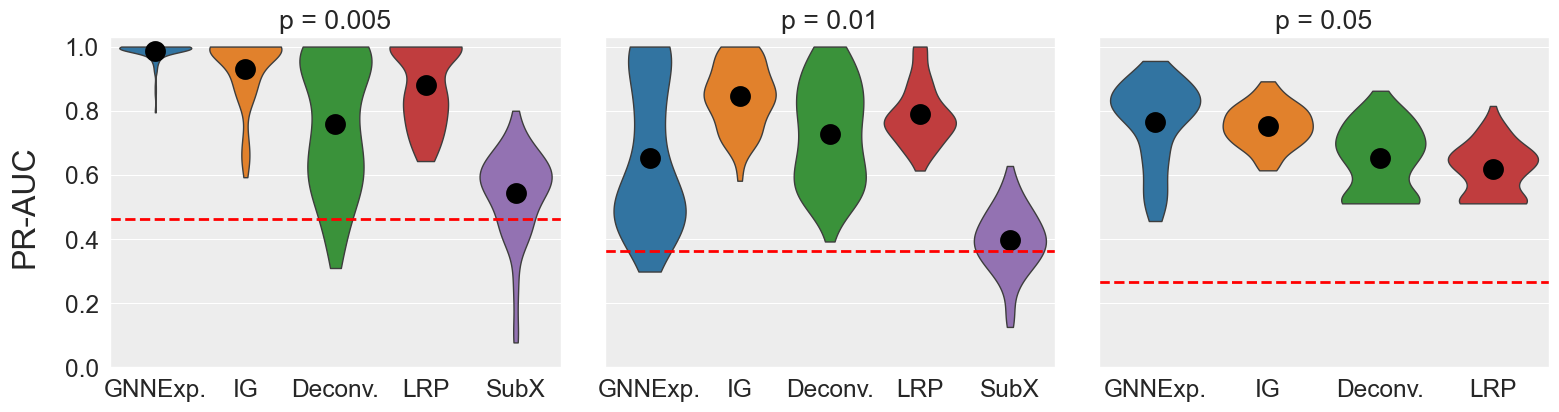

In [174]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge

sns.set_context('paper', font_scale=2)

# get a background color slightly less dark
sns.set_style('darkgrid', {'axes.facecolor': '0.93'})

ps = df['p_edge'].unique()
ps.sort()

h = 0.33
lf = 0.8

lfs = df['labelled_fraction'].unique()
lfs.sort()

fig, axs = plt.subplots(1, len(ps), figsize=(16, 4.5), sharey=True)


for j, p in enumerate(ps):
    if p != 0.05:
        sns.violinplot(x='explainer', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') ],
                        ax=axs[j],hue='explainer', cut=0, inner=None)
        sns.pointplot(x='explainer', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw')],
                        ax=axs[j], linestyles='', markersize=10, lw=0, markers='o', color='black', markeredgewidth=5, )
    else:
        reduced_df = df[df['explainer'] != 'SubX']
        reduced_df['explainer'] = pd.Categorical(reduced_df['explainer'], ['GNNExp.', 'IG', 'Deconv.', 'LRP',])
        sns.violinplot(x='explainer', y='pr_auc',   data=reduced_df[(reduced_df['p_edge'] == p) & (reduced_df['homophily'] == h) & (reduced_df['labelled_fraction']== lf ) & (reduced_df['post_proc']=='Raw')],
                        ax=axs[j],hue='explainer', cut=0, inner=None)
        sns.pointplot(x='explainer', y='pr_auc',   data=reduced_df[(reduced_df['p_edge'] == p) & (reduced_df['homophily'] == h) & (reduced_df['labelled_fraction']== lf ) & (reduced_df['post_proc']=='Raw')],
                        ax=axs[j], linestyles='', markersize=10, lw=0, markers='o', color='black', markeredgewidth=5, )
    axs[j].set_title(f'p = {p}')
    #axs[j].axhline(1, ls='--', color='r', lw=2)
    #random_pr_auc = df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']=='Random')]['pr_auc'].mean()
    #axs[j].axhline(0.25, ls='--', color='r', lw=2)
    axs[j].set_ylabel('')
    
    axs[j].set_ylim(0., 1.03)
    axs[j].set_xlabel('')
    random_mean = random_baseline_df[(random_baseline_df['p_edge'] == p) & (random_baseline_df['homophily'] == h) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['pr_auc'].mean()
    axs[j].axhline(random_mean, ls='--', color='r', lw=2)


#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('PR-AUC')

fig.tight_layout()
fig.savefig(f'../src/results/figures/violinplot_pr_auc_h_{h}_additional_explainers.pdf')


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/143582522.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/143582522.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
/var/folders/jn/nw79

explainer  post_proc 
GNNExp.    Post-proc.    0.987956
           Raw           0.985256
IG         Post-proc.    1.000000
           Raw           0.929966
Deconv.    Post-proc.    1.000000
           Raw           0.757318
LRP        Post-proc.    1.000000
           Raw           0.878729
SubX       Post-proc.    0.534595
           Raw           0.542271
Name: pr_auc, dtype: float64
explainer  post_proc 
GNNExp.    Post-proc.    0.676532
           Raw           0.653922
IG         Post-proc.    1.000000
           Raw           0.845536
Deconv.    Post-proc.    1.000000
           Raw           0.726351
LRP        Post-proc.    1.000000
           Raw           0.790052
SubX       Post-proc.    0.396092
           Raw           0.396092
Name: pr_auc, dtype: float64
explainer  post_proc 
GNNExp.    Post-proc.    0.765719
           Raw           0.765379
IG         Post-proc.    1.000000
           Raw           0.753246
Deconv.    Post-proc.    0.878228
           Raw           0

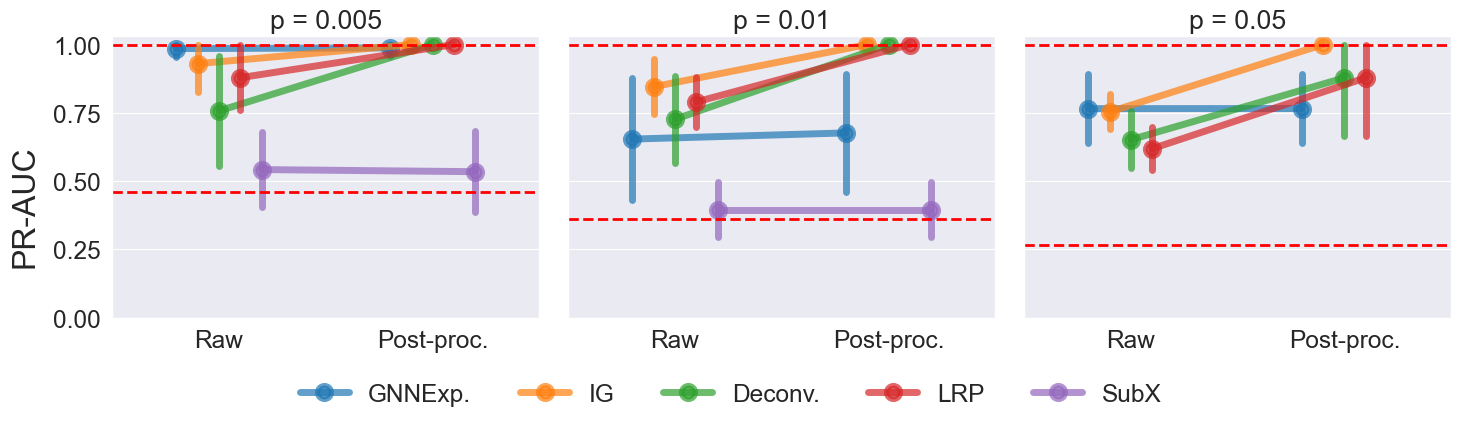

In [175]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge


sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid')

ps = df['p_edge'].unique()
ps.sort()

h = 0.33
lf = 0.8

lfs = df['labelled_fraction'].unique()
lfs.sort()

fig, axs = plt.subplots(1, len(ps), figsize=(15, 4.5), sharey=True)


for j, p in enumerate(ps):
    sns.pointplot(x='post_proc', y='pr_auc',   data=df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')],
                    ax=axs[j],hue='explainer', markersize=10, lw=5, legend=(j==0), errorbar=errorbar_func, alpha=0.7, dodge=.4)
    if j==0:
        axs[j].get_legend().remove()
    print(df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['explainer']!='Random')].groupby(['explainer', 'post_proc']).pr_auc.mean())
    axs[j].set_title(f'p = {p}')
    axs[j].axhline(1, ls='--', color='r', lw=2)
    #random_pr_auc = df[(df['p_edge'] == p) & (df['homophily'] == h) & (df['labelled_fraction']== lf ) & (df['post_proc']=='Raw') & (df['explainer']=='Random')]['pr_auc'].mean()
    random_mean = random_baseline_df[(random_baseline_df['p_edge'] == p) & (random_baseline_df['homophily'] == h) & (random_baseline_df['labelled_fraction']== lf ) & (random_baseline_df['post_proc']=='Raw')]['pr_auc'].mean()
    axs[j].axhline(random_mean, ls='--', color='r', lw=2)
    axs[j].set_ylabel('')
    
    axs[j].set_ylim(0., 1.03)
    axs[j].set_xlabel('')

#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('PR-AUC')

# tight layout but leave some space for the legend on the right
fig.tight_layout()
fig.legend(title='',loc='lower center', ncols=6, frameon=False)
fig.subplots_adjust(bottom=0.25)
fig.savefig(f'../src/results/figures/pointplot_pr_auc_h_{h}_with_PP_additional_explainers.pdf')


## Weight scale exp

In [50]:
# load everyhtin in results/full in a single dataframe
files_list = os.listdir('../src/results/weight_scale_experiment/full')
df = pd.DataFrame()
for file in files_list:
    if file.endswith('.csv') and file.startswith('weight_exp'):
        df = pd.concat([df, pd.read_csv('../src/results/weight_scale_experiment/full/' + file)])

df.drop('Unnamed: 0', axis=1, inplace=True)


# Set a "post_proc" column with True if the explainer has postproc in the name
df['post_proc'] = df['explainer'].apply(lambda x: 'Post-processed' if 'postproc' in x else 'Raw')
# remove postproc from the name
df['explainer'] = df['explainer'].apply(lambda x: x.replace('_postproc', ''))


# Deconvolution with Deconv.
df['explainer'] = df['explainer'].apply(lambda x: 'Deconv.' if x == 'Deconvolution' else x)

# change dataset_type of Arxiv to OGBN-ArXiv
df['dataset_type'] = df['dataset_type'].apply(lambda x: 'OGBN-ArXiv' if x == 'Arxiv' else x)
# change dataset_type of ER to Erdos-Renyi
df['dataset_type'] = df['dataset_type'].apply(lambda x: 'Erdős-Rényi, p=0.05' if x == 'ER' else x)

df = df.sort_values('post_proc', ascending=False)



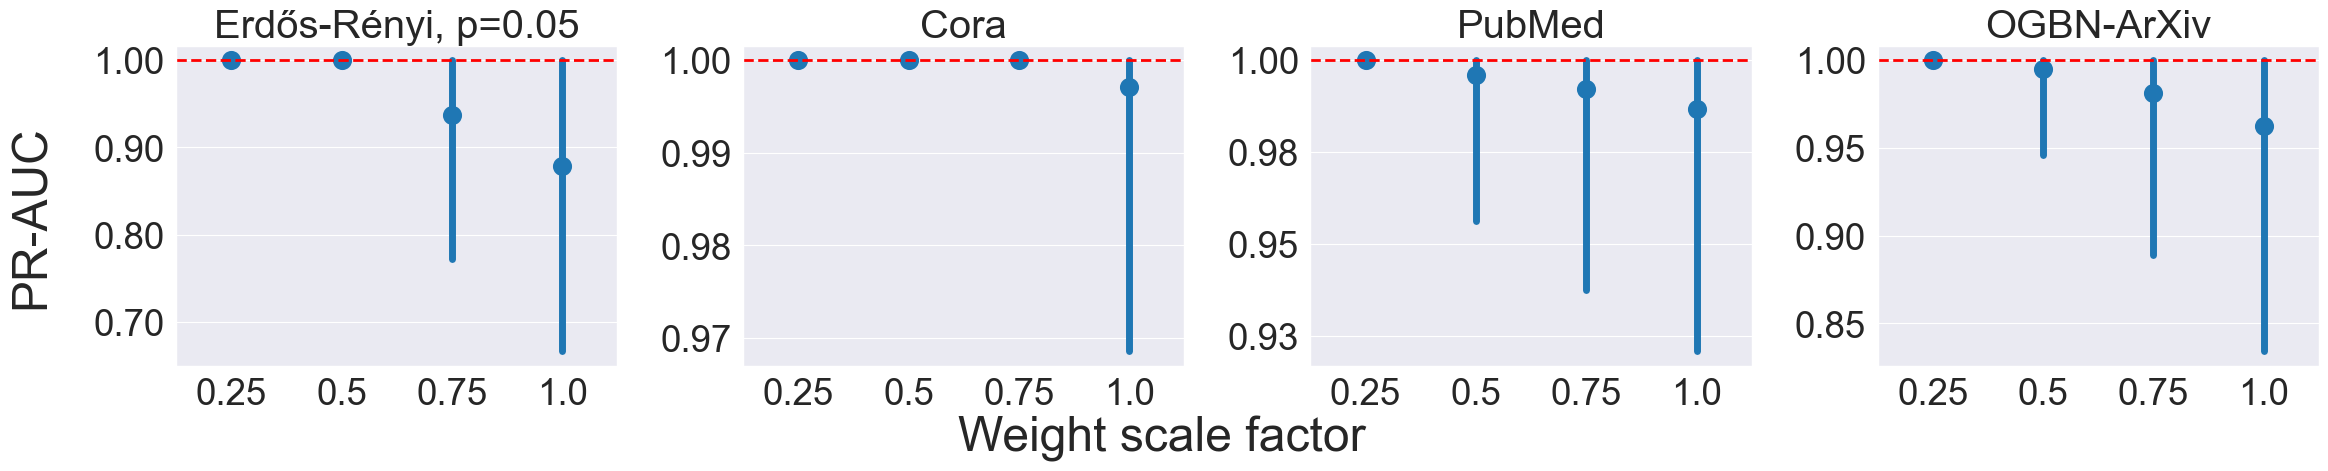

In [55]:
# for each explainer plot a box plot of the pr_auc_mean for each value of p_edge

sns.set_context('paper', font_scale=3)

ps = df['p_edge'].unique()
ps.sort()

h = 0.33

lf=0.80

fig, axs = plt.subplots(1, 4, figsize=(24, 5), sharey=False)

for i, dataset in enumerate(["Erdős-Rényi, p=0.05", "Cora", "PubMed", "OGBN-ArXiv"]):
    sns.pointplot(x='weight_scale', y='pr_auc',  data=df[(df['post_proc']=='Post-processed') & (df['explainer']=='Deconv.') & (df['dataset_type'] == dataset)],
                    ax=axs[i], linestyles='', markersize=10, lw=5, legend=False, errorbar=errorbar_func)

    # draw two horizontal lines at 0.5 and 1
    #axs[j, i].axhline(0.25, ls='--', color='r')
    axs[i].axhline(1, ls='--', color='r', lw=2)
    axs[i].set_ylabel('')
        #axs[j, i].set_ylabel('Precision-Recall AUC')
    #axs.set_ylim(-0.05, 1.05)
    axs[i].set_xlabel('')
    axs[i].set_title(f'{dataset}')

        # set the yticks precision to 2 decimal places
    axs[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
#axs.set_ylim(ymax=1.01)


#fig.suptitle(f'Label propagation model with 2 layers' )

#fig.subplots_adjust(top=0.93)
fig.supylabel('PR-AUC')
fig.supxlabel('Weight scale factor')

fig.tight_layout()
# adjust the xlabel slightly upper
fig.subplots_adjust(bottom=0.20)
fig.savefig(f'../src/results/figures/weight_scale_experiment_all_datasets.pdf')


# Histograms

7992
10757
11654
242182
179124
179595


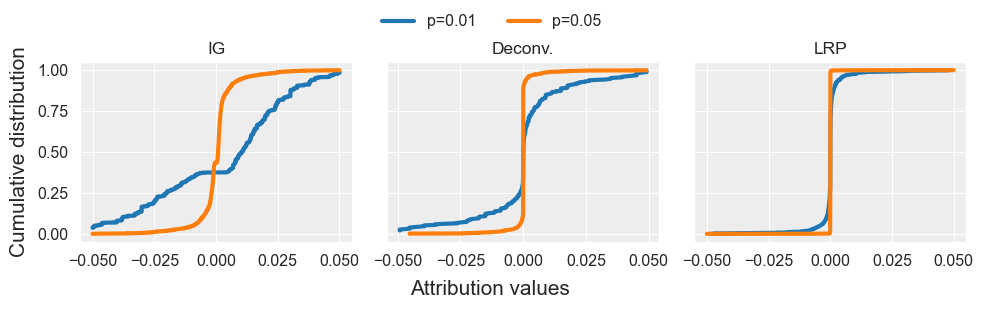

In [112]:
sns.set_context('paper', font_scale=1.3)
sns.set_style('darkgrid', {'axes.facecolor': '0.93'})
ps =  [0.01, 0.05]
explainer_names = {'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP'}

dataset_names = ['ER__p_0.01__h_0.33__lf_0.80__LPModel__ws_1.0', 'ER__p_0.05__h_0.33__lf_0.80__LPModel__ws_1.0']

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i, dataset_name in enumerate(dataset_names):
    for j, explainer in enumerate(['IntegratedGradients', 'Deconvolution', 'LRP']):
        explanation = []
        for seed in range(3030, 3030+1):
            curr_explanations = np.load(f'../src/results/weight_scale_experiment/explanations/{explainer}__{dataset_name}__s_{seed}.npy', allow_pickle=True)
            explanation.extend(curr_explanations)
        explanation = np.concatenate(explanation)
        start_count = np.sum(explanation < -0.05)/len(explanation)
        end_count = np.sum(explanation <= 0.05)/len(explanation)
        explanation = explanation[(explanation!=0) & (np.abs(explanation) < 0.05)]
        print(len(explanation))
        if len(explanation) > 5000:
            explanation = np.random.choice(explanation, 5000)
        explanation = np.sort(explanation)
        cumulative = np.arange(len(explanation))/len(explanation)*end_count + start_count
        if i==1 and j==2:
            explanation = np.concatenate([[-0.05], explanation, [0.05]])
            cumulative = np.concatenate([[0], cumulative, [1]])
        if j == 0:
            sns.lineplot(x=explanation, y=cumulative, ax=axs[j], label=f'p={ps[i]}', legend=False, lw=3)
        else:
            sns.lineplot(x=explanation, y=cumulative, ax=axs[j], legend=False, lw=3)
        axs[j].set_ylabel('')
        if i == 0:
            axs[j].set_title(explainer_names[explainer])
            #axs[j].set_yscale('log')

fig.supxlabel('Attribution values')
fig.supylabel('Cumulative distribution')
fig.legend(title='', loc='upper center', ncols=2, frameon=False)

fig.tight_layout()
fig.subplots_adjust(top=0.8, bottom=0.2)
fig.savefig(f'../src/results/figures/explanations_histograms.pdf')
        

# Using different thresholds

## synth

/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/4135665837.py:30: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])


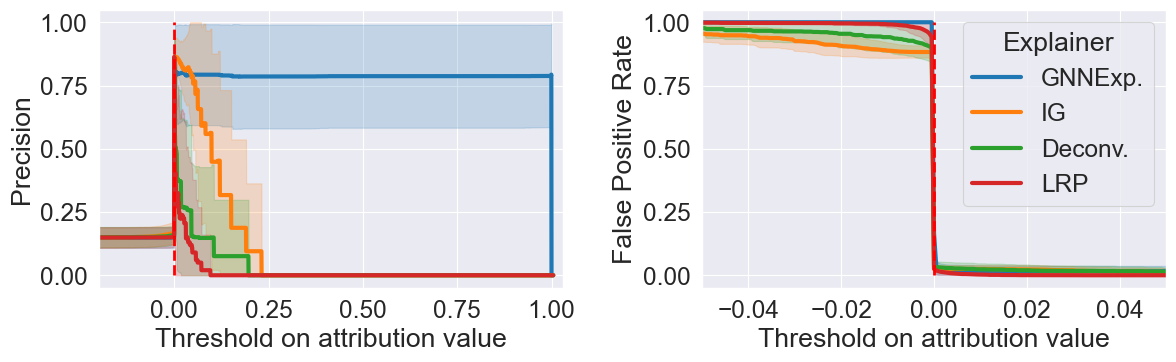

In [162]:
sns.set_context('paper', font_scale=2)

explainer_names = {'GNNExplainer': 'GNNExp.', 'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP', 'SubgraphX': 'SubX'} #

dataset_name = 'ER__p_0.01__h_0.33__lf_0.80__LPModel__s_3030'

curr_gt_explanation = np.load(f'../src/results/explanations/ground_truth__{dataset_name}.npy', allow_pickle=True)
difficult_negatives = np.load(f'../src/results/explanations/difficult_negatives__{dataset_name}.npy', allow_pickle=True)

thresholds = np.arange(-0.2, 1.005, 0.0005)

results = []

for explainer in ['GNNExplainer', 'IntegratedGradients', 'Deconvolution', 'LRP',]: # 'SubgraphX'
    explanation = np.load(f'../src/results/explanations/{explainer}__{dataset_name}.npy', allow_pickle=True)
    # for each threshold, compute false positive rate, true positive rate, precision, wrong difficult negatives rate
    for threshold in thresholds:
        for k in range(100):
            binarized = explanation[k] > threshold
            tp = np.sum(binarized & curr_gt_explanation[k])
            fp = np.sum(binarized & ~curr_gt_explanation[k])
            tn = np.sum(~binarized & ~curr_gt_explanation[k])
            fn = np.sum(~binarized & curr_gt_explanation[k])
            if tp + fp == 0:
                precision = 0
            else:
                precision = tp / (tp + fp)
            false_positive_rate = fp / (fp + tn)
            false_negative_rate = fn / (fn + tp)
            wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
            results.append({'explainer': explainer_names[explainer], 'indx': k, 'threshold': threshold, 'precision': precision, 'false_positive_rate': false_positive_rate, 'false_negative_rate': false_negative_rate, 'wrong_difficult_negatives_rate': wrong_difficult_negatives_rate})

df = pd.DataFrame(results)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, metric in enumerate(['precision', 'false_positive_rate']):
    sns.lineplot(x='threshold', y=metric, data=df, hue='explainer', ax=axs[i], lw=3, errorbar=errorbar_func)
    axs[i].set_xlabel('Threshold on attribution value')
    # dump the second legend
    if i == 0:
        axs[i].get_legend().remove()
    else:
        #position the legend in the upper right corner
        axs[i].legend(loc='upper right', title='Explainer')
    axs[i].set_ylim(-0.05, 1.05)
    if i==1:
        axs[i].set_xlim(-0.05, 0.05)
    else:
        axs[i].set_xlim(-0.2, 1.03)
    axs[i].vlines(0, 0, 1, color='r', ls='--', lw=2)


axs[0].set_ylabel('Precision')
axs[1].set_ylabel('False Positive Rate')

fig.tight_layout()
#fig.supxlabel()
fig.subplots_adjust(wspace=0.3)

fig.savefig(f'../src/results/figures/fpr_Vs_Prec__{dataset_name}.pdf')


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1965971954.py:35: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1965971954.py:35: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])


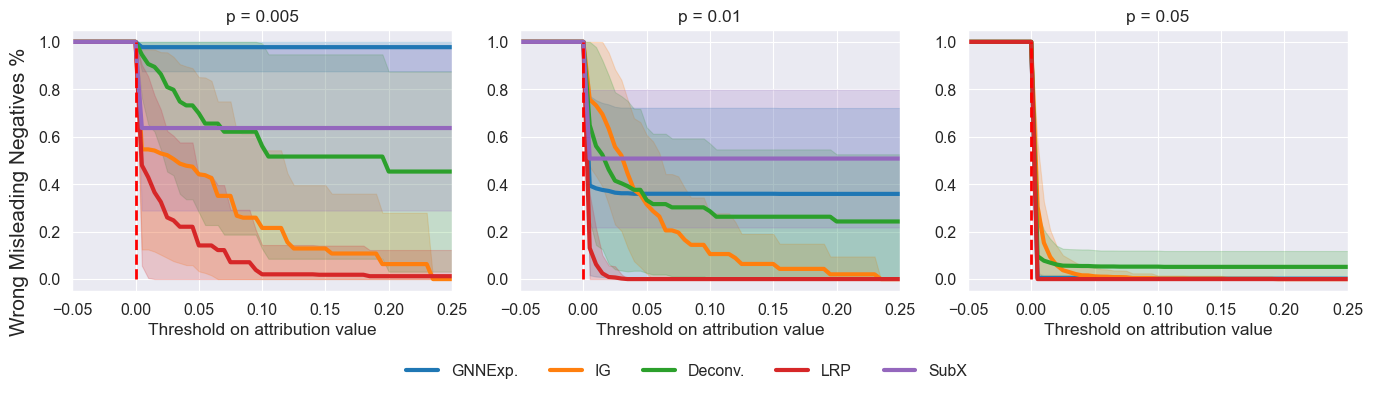

In [178]:

sns.set_context('paper', font_scale=1.3)

explainer_names = {'GNNExplainer': 'GNNExp.', 'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP', 'SubgraphX': 'SubX'} #

thresholds = np.arange(-0.05, 0.305, 0.005)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
datasets = ['ER__p_0.005__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.01__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.05__h_0.33__lf_0.80__LPModel__s_3030']

ps = [0.005, 0.01, 0.05]


for i,dataset_name in enumerate(datasets):

    curr_gt_explanation = np.load(f'../src/results/explanations/ground_truth__{dataset_name}.npy', allow_pickle=True)
    difficult_negatives = np.load(f'../src/results/explanations/difficult_negatives__{dataset_name}.npy', allow_pickle=True)
    results = []
    for explainer in ['GNNExplainer', 'IntegratedGradients', 'Deconvolution', 'LRP', 'SubgraphX',]:
        if i==2 and explainer == 'SubgraphX':
            continue
        explanation = np.load(f'../src/results/explanations/{explainer}__{dataset_name}.npy', allow_pickle=True)
        # for each threshold, compute false positive rate, true positive rate, precision, wrong difficult negatives rate
        for threshold in thresholds:
            for k in range(100):
                binarized = explanation[k] > threshold
                tp = np.sum(binarized & curr_gt_explanation[k])
                fp = np.sum(binarized & ~curr_gt_explanation[k])
                tn = np.sum(~binarized & ~curr_gt_explanation[k])
                fn = np.sum(~binarized & curr_gt_explanation[k])
                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)
                false_positive_rate = fp / (fp + tn)
                false_negative_rate = fn / (fn + tp)
                wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
                results.append({'explainer': explainer_names[explainer], 'indx': k, 'threshold': threshold, 'precision': precision, 'false_positive_rate': false_positive_rate, 'false_negative_rate': false_negative_rate, 'wrong_difficult_negatives_rate': wrong_difficult_negatives_rate})

    df = pd.DataFrame(results)

    sns.lineplot(x='threshold', y='wrong_difficult_negatives_rate', data=df, hue='explainer', ax=axs[i], lw=3, errorbar=errorbar_func, legend=(i==0))
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    if i==0:
        axs[i].get_legend().remove()
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_title(f'p = {ps[i]}')
    axs[i].set_xlim(-0.05, 0.25)
    # vline at 0
    axs[i].vlines(0, 0, 1, ls='--', color='r',lw=2)
    axs[i].set_xlabel('Threshold on attribution value')

#fig.supxlabel('Threshold')
fig.supylabel('Wrong Misleading Negatives %')


fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.legend(loc='lower center', ncol=7, frameon=False)

fig.savefig(f'../src/results/figures/difficult_negatives__{dataset_name}.pdf')


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1177270100.py:35: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/1177270100.py:35: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])


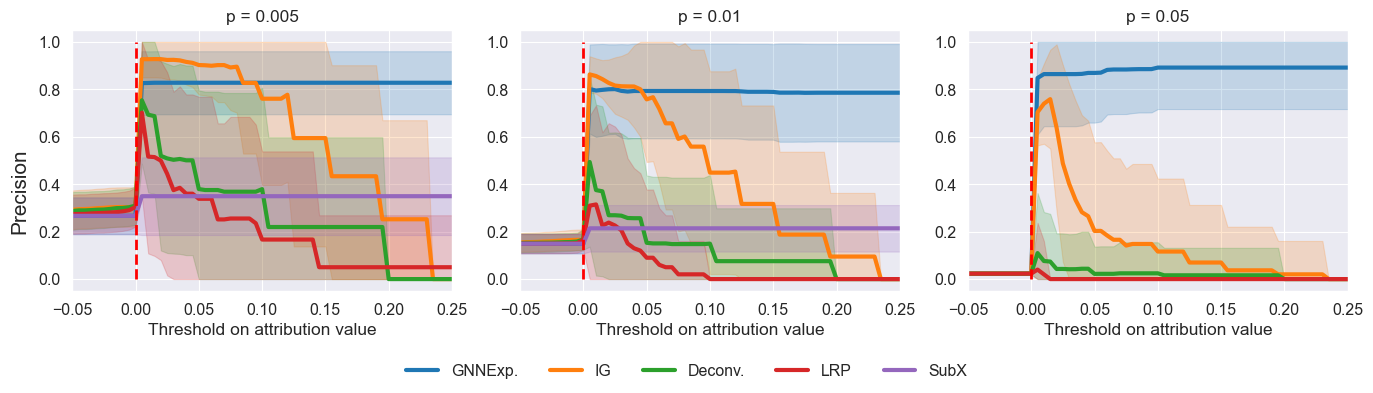

In [179]:

sns.set_context('paper', font_scale=1.3)

explainer_names = {'GNNExplainer': 'GNNExp.', 'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP', 'SubgraphX': 'SubX'} #

thresholds = np.arange(-0.05, 0.305, 0.005)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
datasets = ['ER__p_0.005__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.01__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.05__h_0.33__lf_0.80__LPModel__s_3030']

ps = [0.005, 0.01, 0.05]


for i,dataset_name in enumerate(datasets):

    curr_gt_explanation = np.load(f'../src/results/explanations/ground_truth__{dataset_name}.npy', allow_pickle=True)
    difficult_negatives = np.load(f'../src/results/explanations/difficult_negatives__{dataset_name}.npy', allow_pickle=True)
    results = []
    for explainer in ['GNNExplainer', 'IntegratedGradients', 'Deconvolution', 'LRP', 'SubgraphX',]:
        if i==2 and explainer == 'SubgraphX':
            continue
        explanation = np.load(f'../src/results/explanations/{explainer}__{dataset_name}.npy', allow_pickle=True)
        # for each threshold, compute false positive rate, true positive rate, precision, wrong difficult negatives rate
        for threshold in thresholds:
            for k in range(100):
                binarized = explanation[k] > threshold
                tp = np.sum(binarized & curr_gt_explanation[k])
                fp = np.sum(binarized & ~curr_gt_explanation[k])
                tn = np.sum(~binarized & ~curr_gt_explanation[k])
                fn = np.sum(~binarized & curr_gt_explanation[k])
                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)
                false_positive_rate = fp / (fp + tn)
                false_negative_rate = fn / (fn + tp)
                wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
                results.append({'explainer': explainer_names[explainer], 'indx': k, 'threshold': threshold, 'precision': precision, 'false_positive_rate': false_positive_rate, 'false_negative_rate': false_negative_rate, 'wrong_difficult_negatives_rate': wrong_difficult_negatives_rate})

    df = pd.DataFrame(results)

    sns.lineplot(x='threshold', y='precision', data=df, hue='explainer', ax=axs[i], lw=3, errorbar=errorbar_func, legend=(i==0))
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    if i==0:
        axs[i].get_legend().remove()
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_title(f'p = {ps[i]}')
    axs[i].set_xlim(-0.05, 0.25)
    # vline at 0
    axs[i].vlines(0, 0, 1, ls='--', color='r', lw=2)
    axs[i].set_xlabel('Threshold on attribution value')

#fig.supxlabel('Threshold')
fig.supylabel('Precision')


fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.legend(loc='lower center', ncol=6, frameon=False)
fig.savefig(f'../src/results/figures/difficult_negatives__{dataset_name}.pdf')


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/3018825936.py:37: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/3018825936.py:37: RuntimeWarning: invalid value encountered in scalar divide
  wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])


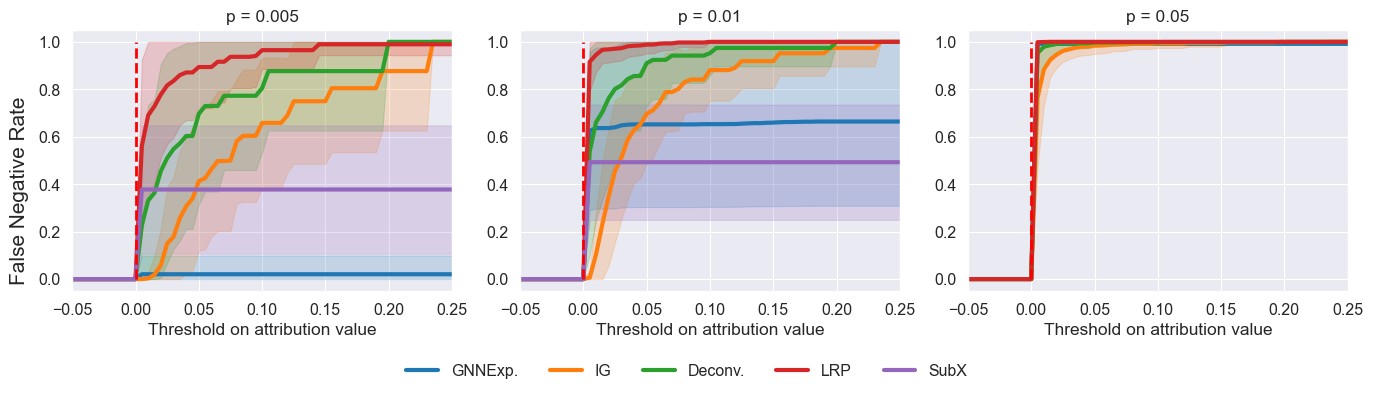

In [180]:

sns.set_context('paper', font_scale=1.3)

explainer_names = {'GNNExplainer': 'GNNExp.', 'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP', 'SubgraphX': 'SubX',} #

thresholds = np.arange(-0.05, 0.305, 0.005)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
datasets = ['ER__p_0.005__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.01__h_0.33__lf_0.80__LPModel__s_3030', 'ER__p_0.05__h_0.33__lf_0.80__LPModel__s_3030']

ps = [0.005, 0.01, 0.05]


for i,dataset_name in enumerate(datasets):

    curr_gt_explanation = np.load(f'../src/results/explanations/ground_truth__{dataset_name}.npy', allow_pickle=True)
    difficult_negatives = np.load(f'../src/results/explanations/difficult_negatives__{dataset_name}.npy', allow_pickle=True)
    results = []
    for explainer in ['GNNExplainer', 'IntegratedGradients', 'Deconvolution', 'LRP', 'SubgraphX',]:
        if i==2 and explainer == 'SubgraphX':
            continue
        explanation = np.load(f'../src/results/explanations/{explainer}__{dataset_name}.npy', allow_pickle=True)
        if explainer == 'FlowX':
            print(np.min(np.concatenate(explanation)), np.max(np.concatenate(explanation)))
        # for each threshold, compute false positive rate, true positive rate, precision, wrong difficult negatives rate
        for threshold in thresholds:
            for k in range(100):
                binarized = explanation[k] > threshold
                tp = np.sum(binarized & curr_gt_explanation[k])
                fp = np.sum(binarized & ~curr_gt_explanation[k])
                tn = np.sum(~binarized & ~curr_gt_explanation[k])
                fn = np.sum(~binarized & curr_gt_explanation[k])
                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)
                false_positive_rate = fp / (fp + tn)
                false_negative_rate = fn / (fn + tp)
                wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
                results.append({'explainer': explainer_names[explainer], 'indx': k, 'threshold': threshold, 'precision': precision, 'false_positive_rate': false_positive_rate, 'false_negative_rate': false_negative_rate, 'wrong_difficult_negatives_rate': wrong_difficult_negatives_rate})

    df = pd.DataFrame(results)

    sns.lineplot(x='threshold', y='false_negative_rate', data=df, hue='explainer', ax=axs[i], lw=3, errorbar=errorbar_func, legend=(i==0))
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    if i==0:
        axs[i].get_legend().remove()
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_title(f'p = {ps[i]}')
    axs[i].set_ylim(-0.05, 1.05)
    axs[i].set_title(f'p = {ps[i]}')
    axs[i].set_xlim(-0.05, 0.25)
    # vline at 0
    axs[i].vlines(0, 0, 1, ls='--', color='r', lw=2)
    axs[i].set_xlabel('Threshold on attribution value')

fig.supylabel('False Negative Rate')


fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.legend(loc='lower center', ncol=6, frameon=False)

fig.savefig(f'../src/results/figures/false_negatives__{dataset_name}.pdf')


## real

/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/242883365.py:37: RuntimeWarning: invalid value encountered in scalar divide
  false_positive_rate = fp / (fp + tn)


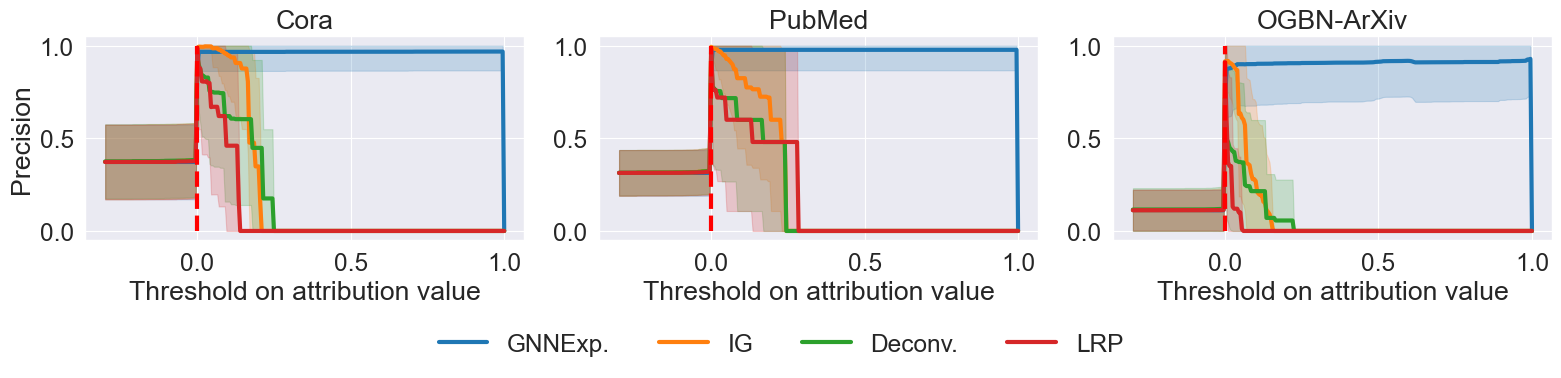

In [109]:
sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid')

explainer_names = {'GNNExplainer': 'GNNExp.', 'IntegratedGradients': 'IG', 'Deconvolution': 'Deconv.', 'LRP': 'LRP'}

datasets_list = ['Cora__lf_0.80__GeneralLPModel__s_3030', 'PubMed__lf_0.80__GeneralLPModel__s_3030', 'Arxiv__lf_0.80__GeneralLPModel__s_3030'] #

dataset_title_names = {'Cora__lf_0.80__GeneralLPModel__s_3030': 'Cora', 'PubMed__lf_0.80__GeneralLPModel__s_3030': 'PubMed', 'Arxiv__lf_0.80__GeneralLPModel__s_3030': 'OGBN-ArXiv'}

df_dict ={}

for m, dataset_name in enumerate(datasets_list):

    curr_gt_explanation = np.load(f'../src/results/explanations/ground_truth__{dataset_name}.npy', allow_pickle=True)
    difficult_negatives = np.load(f'../src/results/explanations/difficult_negatives__{dataset_name}.npy', allow_pickle=True)

    thresholds = np.arange(-0.3, 1.005, 0.005)

    results = []
    

    for explainer in ['GNNExplainer', 'IntegratedGradients', 'Deconvolution', 'LRP',]:
        explanation = np.load(f'../src/results/explanations/{explainer}__{dataset_name}.npy', allow_pickle=True)

        # for each threshold, compute false positive rate, true positive rate, precision, wrong difficult negatives rate
        for threshold in thresholds:
            for k in range(100):
                binarized = explanation[k] > threshold
                tp = np.sum(binarized & curr_gt_explanation[k])
                fp = np.sum(binarized & ~curr_gt_explanation[k])
                tn = np.sum(~binarized & ~curr_gt_explanation[k])
                fn = np.sum(~binarized & curr_gt_explanation[k])
                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)
                false_positive_rate = fp / (fp + tn)
                false_negative_rate = fn / (fn + tp)
                if np.sum(difficult_negatives[k]) == 0:
                    wrong_difficult_negatives_rate = None
                else:
                    wrong_difficult_negatives_rate = np.sum(binarized & difficult_negatives[k]) / np.sum(difficult_negatives[k])
                results.append({'explainer': explainer_names[explainer], 'indx': k, 'threshold': threshold, 'precision': precision, 'false_positive_rate': false_positive_rate, 'false_negative_rate': false_negative_rate, 'wrong_difficult_negatives_rate': wrong_difficult_negatives_rate})

    df = pd.DataFrame(results)

    df.threshold = df.threshold.astype(float)

    df_dict[dataset_name] = df.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for m, dataset_name in enumerate(datasets_list):
    df = df_dict[dataset_name]
    for i, metric in enumerate(['precision', ]): #' false_negative_rate', 'wrong_difficult_negatives_rate'
        sns.lineplot(x='threshold', y=metric, data=df, hue='explainer', ax=axs[m], errorbar=errorbar_func, legend=(m==0) and(i==0), lw=3)
        if i==0 and m==0:
            axs[m].get_legend().remove()

        axs[m].vlines(0, 0, 1, color='r', linestyles='--', lw=3)
        #if m == 1:
        axs[m].set_xlabel('Threshold on attribution value')
#
        axs[m].set_ylabel('')
    
    #axs[m].set_xlabel('Threshold')
    
    axs[m].set_title(dataset_title_names[dataset_name])


axs[0].set_ylabel('Precision')

# axs[1, 0].set_ylabel('False Negative Rate')
# axs[2, 0].set_ylabel('Wrong Difficult Negatives %')

#fig.supxlabel('Threshold on attribution value')
fig.tight_layout()
fig.legend(title='', loc='lower center', ncols=4, frameon=False)
fig.subplots_adjust(bottom=0.35)

    
fig.savefig(f'../src/results/figures/precision_with_thresholds__real_datasets.pdf')

# GNNExplainer parameters

In [150]:
# load everyhtin in results/full in a single dataframe
files_list = os.listdir('../src/results/gnnexplainer_exps')
df = pd.DataFrame()
for file in files_list:
    if file.endswith('.csv') and file.startswith('ER'):
        df = pd.concat([df, pd.read_csv('../src/results/gnnexplainer_exps/' + file)])

df.drop('Unnamed: 0', axis=1, inplace=True)

df['epochs'] = df['explainer'].apply(lambda x: int(x.split('__epochs_')[-1]) if 'epochs' in x else None)
df['edge_size'] = df['explainer'].apply(lambda x: float(x.split('__edge_size_')[-1]) if 'edge_size' in x else None)

df['explainer'] = 'GNNExplainer'

df

,node_idx,explainer,pr_auc,roc_auc,f1,false_negative_rate,false_positive_rate,difficult_false_positives,precision,dataset_type,num_nodes,p_edge,homophily,labelled_fraction,seed,whitebox,epochs,edge_size
0,212,GNNExplainer,0.869224,0.966667,0.740741,0.0,0.291667,1.0,0.588235,ER,1000,0.005,0.33,0.8,3030,LPModel,10.0,NaN
1,425,GNNExplainer,0.942967,0.981481,0.800000,0.0,0.214286,1.0,0.666667,ER,1000,0.005,0.33,0.8,3030,LPModel,10.0,NaN
2,728,GNNExplainer,0.946822,0.977273,0.689655,0.0,0.409091,1.0,0.526316,ER,1000,0.005,0.33,0.8,3030,LPModel,10.0,NaN
3,216,GNNExplainer,0.993818,0.997863,0.720000,0.0,0.269231,1.0,0.562500,ER,1000,0.005,0.33,0.8,3030,LPModel,10.0,NaN
4,856,GNNExplainer,1.000000,1.000000,0.888889,0.0,0.166667,NaN,0.800000,ER,1000,0.005,0.33,0.8,3030,LPModel,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,544,GNNExplainer,0.499181,0.984391,0.580950,0.0,0.039105,1.0,0.409394,ER,1000,0.050,0.33,0.8,3030,LPModel,NaN,1.0
3596,979,GNNExplainer,0.536950,0.986617,0.642825,0.0,0.031472,1.0,0.473649,ER,1000,0.050,0.33,0.8,3030,LPModel,NaN,1.0
3597,82,GNNExplainer,0.585356,0.989270,0.656424,0.0,0.026936,1.0,0.488565,ER,1000,0.050,0.33,0.8,3030,LPModel,NaN,1.0
3598,946,GNNExplainer,0.524398,0.988113,0.615028,0.0,0.029667,1.0,0.444073,ER,1000,0.050,0.33,0.8,3030,LPModel,NaN,1.0


/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/3986545606.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([10, 30, 100, 300, 1000, 3000, 10000])


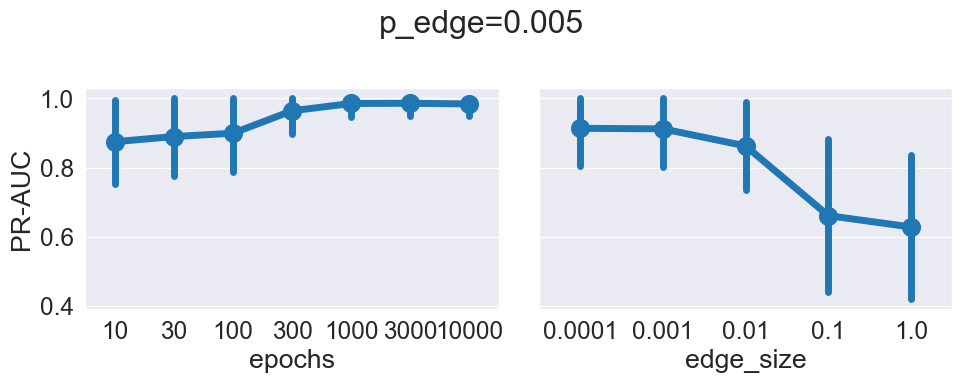

/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/3986545606.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([10, 30, 100, 300, 1000, 3000, 10000])


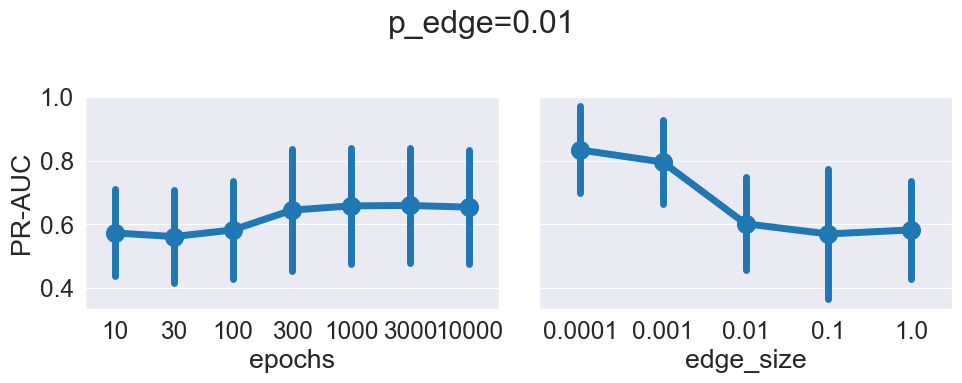

/var/folders/jn/nw79qpfd0812n0rw61rbzj0c0000gn/T/ipykernel_83980/3986545606.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([10, 30, 100, 300, 1000, 3000, 10000])


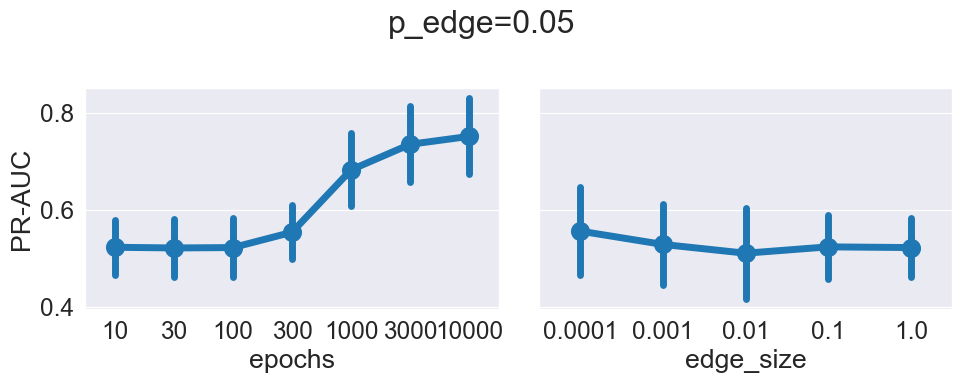

In [156]:
# plot the pr_auc according to the number of epochs and the edge size
sns.set_context('paper', font_scale=2)
sns.set_style('darkgrid')

ps = df['p_edge'].unique()
ps.sort()
for p in ps:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    sns.pointplot(x='epochs', y='pr_auc',  data=df[(df['edge_size'].isna()) & (df['p_edge']== p )], ax=axs[0],
                    markersize=10, lw=5, errorbar=errorbar_func)
    sns.pointplot(x='edge_size', y='pr_auc',  data=df[(df['epochs'].isna()) & (df['p_edge']== p )], ax=axs[1],
                    markersize=10, lw=5,  errorbar=errorbar_func)
    fig.suptitle(f'p_edge={p}')
    axs[0].set_ylabel('PR-AUC')
    # set xticks with no decimal places for first plot
    axs[0].set_xticklabels([10, 30, 100, 300, 1000, 3000, 10000])
    
    #axs[0].set_xscale('log')
    fig.tight_layout()
    fig.savefig(f'../src/results/figures/gnnexplainer_params_exp_p_{p}.pdf')

    
    plt.show()

